# House Prices: Advanced Regression Techniques

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home, using dataset available on Kaggle:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## Goal
Our goal as a Data Scientist is to identify the most important variables and to define the best regression model for predicting the housing prices in Ames, Iowa. This analysis will be divided into five stages:

- Exploratory data analysis (EDA);
- Data Pre-processing;
- Feature engineering;
- Modeling;
- Hyperparameter tuning
- Ensembling.

It is our job to predict the sales price for each house. For each Id in the test set, you must predict the value of the ``SalePrice`` variable. 


## House Prices Dataset

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

Desctiption of all variables could be found on `data_description.txt`

In [1]:
# Import necessary libraries

%matplotlib inline
import numpy as np
import pandas as pd 
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [2]:
# Read Train House Prices Dataset
df_train = pd.read_csv('data/train.csv')
df_train.head()

# Read Test House Prices Dataset
df_test = pd.read_csv('data/test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Exploratory Data Analysis

In order to understand our data, we can look at variable, structure and try to understand their meaning and relevance to this problem.

### Overview

In [3]:
# Let's see the shape of dataset
df_train.shape

(1460, 81)

In [4]:
# Let's see some informations about it
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Missing Data at Attributes

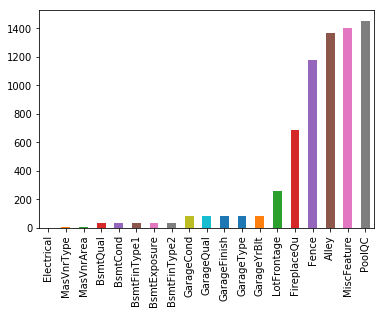

In [5]:
missingData = df_train.isnull().sum()
missingData = missingData[missingData > 0]
missingData.sort_values(inplace=True)
missingData.plot.bar()

Dataset has 19 attributes with missing values and 5 over 50% of all data. However, most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement, for instance.

### Analyzing SalePrices
'SalePrice' is the reason of our quest.

In [6]:
target = df_train['SalePrice']
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


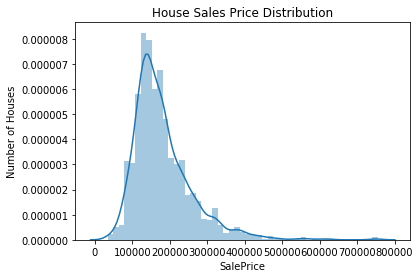

In [7]:
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")
sns.distplot(target)

According with picture, we can see ``SalePrices`` has:
- Deviate from the normal distribution.
- Have appreciable positive skewness.

As the distribution has a skewed to the right, we have a higher concentration of expensive homes than cheaper homes.

#### Normalizing ``SalePrices``
To make this distribution more symmetrical, we can try use a logarithm scale. Let's try this.

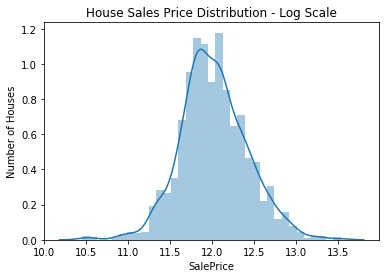

In [8]:
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution - Log Scale")
sns.distplot(np.log(target))

Taking the logarithm from our target variable, we obtain something similar to a Gaussian distribution. This will ensure that relative errors for cheaper and more expensive homes are treated on an equal footing.

#### Creating ``SalePrices`` with Log Scale

In [9]:
df_train['SalePriceLog'] = np.log(df_train['SalePrice'])
target = np.log(target)

### Numerical Variables
Let’s start by seeing which of our features are numeric.

In [10]:
numeric_features = df_train.select_dtypes(include=np.number)
numeric_features.shape

(1460, 39)

As we can see, there are 39 numeric features. However, we are counting `Id`, `SalePrice` and `SalePriceLog`.

Next important step is see how our predictors correlate, positively and negatively, to our target variable.

#### Correlation

In [11]:
# Remove Id and SalePrice features from our numeric features
numeric_features.drop(['Id', 'SalePrice'], axis=1, inplace=True)
numeric_features.shape

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(1460, 37)

Let's see top 10 positive and negative correlation between numerical variables.

In [12]:
corr = numeric_features.corr()
print(corr['SalePriceLog'].sort_values(ascending=False)[:10], '\n')
print(corr['SalePriceLog'].sort_values(ascending=False)[-10:])

SalePriceLog    1.000000
OverallQual     0.817184
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePriceLog, dtype: float64 

3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePriceLog, dtype: float64


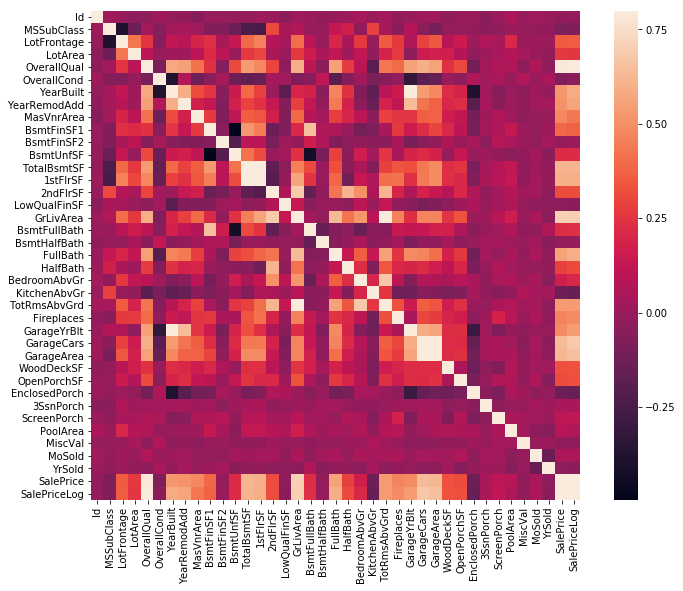

In [13]:
# Correlation matrix
corr_matrix = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.8, square=True)

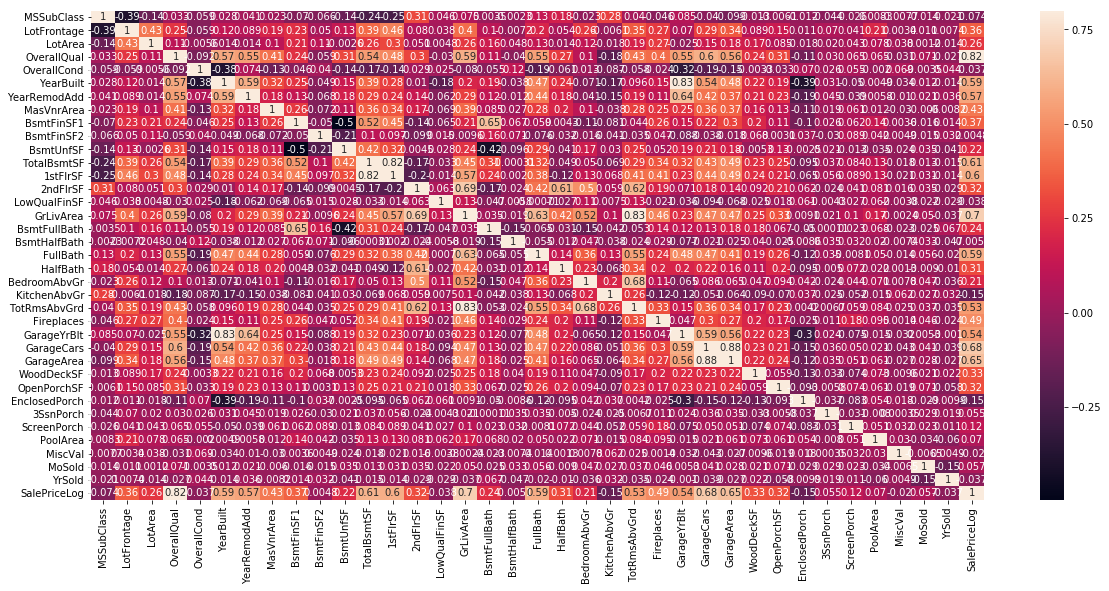

In [14]:
#correlation matrix
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 10}, annot=True);

If we observe closely the heatmap it stands out the strong positive correlation relationship of value between `OverallQual`, `GrLivArea`, `GarageCars` and some other strong negative correlation, for instance, `EnclosedPorch`, `KitchenAbvGr`, `MSSubClass` and among others.        

These correlations are so strong that it can indicate a situation of multicollinearity (redundancy). If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs.

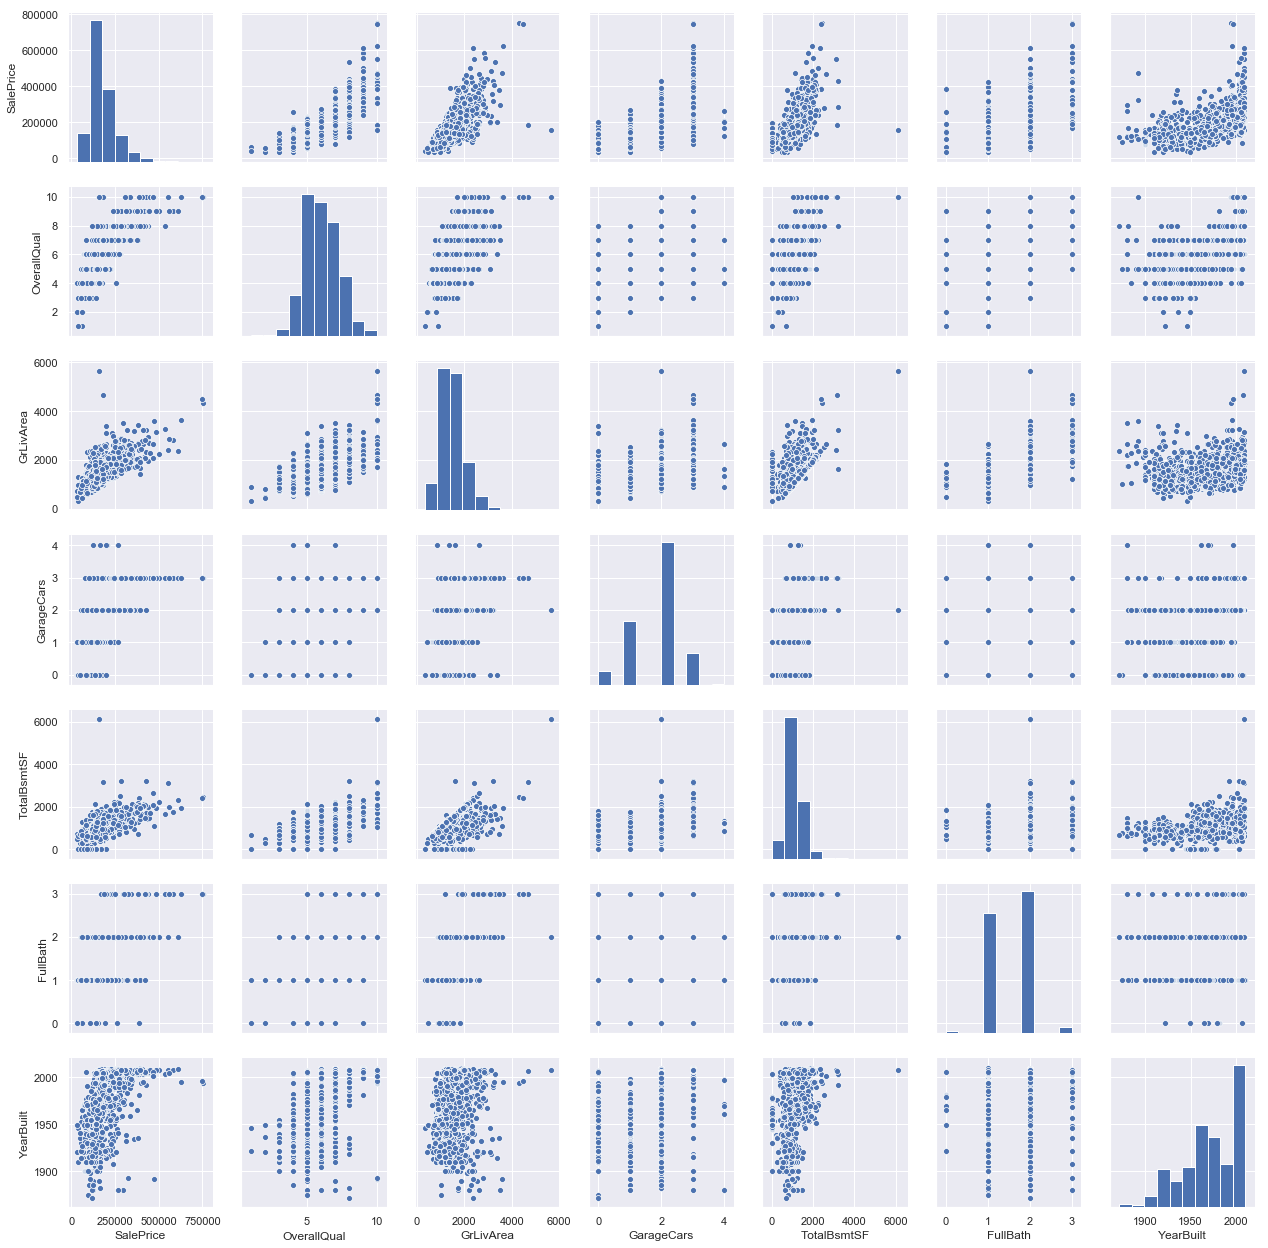

In [15]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)
plt.show();

One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.

The plot concerning 'SalePrice' and 'YearBuilt' can also make us think. In the bottom of the 'dots cloud', we see what almost appears to be a shy exponential function (be creative). We can also see this same tendency in the upper limit of the 'dots cloud' (be even more creative). Also, notice how the set of dots regarding the last years tend to stay above this limit (I just wanted to say that prices are increasing faster now).

### Categorical Variables
Let’s continue our analysis seeing which of our features are categorical.

#### Distribution of the variable `BedroomAbvG`
We made the assumption that the number of bedrooms in a house could have an impact in the sales price. Let’s check the distribution the number of rooms availables per each house.

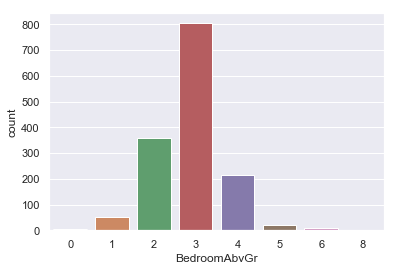

In [16]:
sns.countplot(df_train['BedroomAbvGr'])

As we can see, most houses have on average three bedrooms.

#### Distribution of the variable `TotRmsAbvGrd`
As we saw above, most houses have three bedrooms. Therefore, it is expected that most of them will have in total at least six divisions counting the kitchen, living room and dining room.

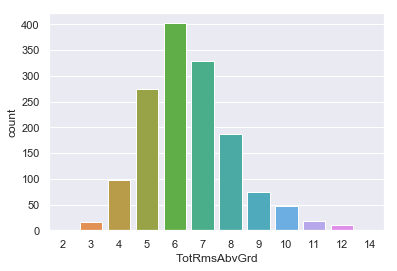

In [17]:
sns.countplot(df_train['TotRmsAbvGrd'])

#### Distribution of the variable `Fireplace`
We made the assumption if a house has a fireplace, the price can increase. So let's see how many houses have one.

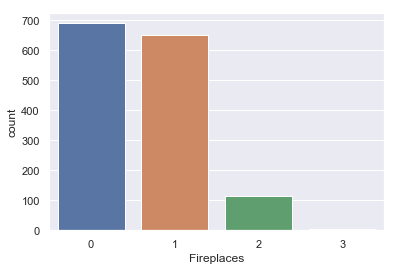

In [18]:
sns.countplot(df_train['Fireplaces'])

#### Distribution of the variable `PoolArea`
Houses usually has high prices when there is a pool. So, let's see how many one there in our dataset.

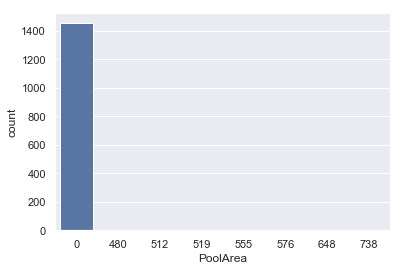

In [19]:
sns.countplot(df_train['PoolArea'])

In [20]:
print('Number of houses that has pool: ', df_train[df_train['PoolArea'] > 0].shape[0]) 

Number of houses that has pool:  7


There are just seven houses that has pool. This makes sense since this is a location where, in winter, temperatures drop to -0ºC. To confirme our teory, let's see `Heating` variable.

#### Distribution of the variable `Heating`

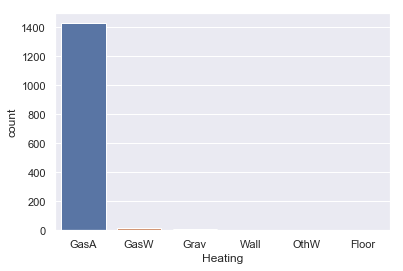

In [21]:
sns.countplot(df_train['Heating'])

We’ve saw the most of houses have fireplaces and/or heating system installed. So, the fact that only 7 houses from 1460 have a pool is not a surprise. Be aware that 1453 have NaN for this variable.

#### Distribution of the variable `GarageCars`
This is one the most important variable that a person when has a car look for in a house. So, let's take a look in this variable.

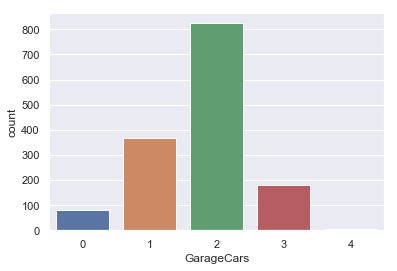

In [22]:
sns.countplot(df_train['GarageCars'])

As we can see, on average each house has 2 parking spaces

#### Distribution of the variable `OverallQual`
This is another feature tha can make a house more expensive. So let's take a look

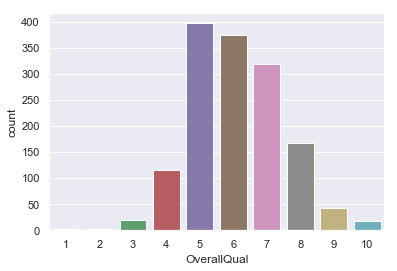

In [23]:
sns.countplot(df_train['OverallQual'])

It makes sense, once in our dataset the most of houses are expensive and the material and finish are good.

#### Distribution of the variable `KitchenQual`
Let's take a look in a kitchen quality feature.

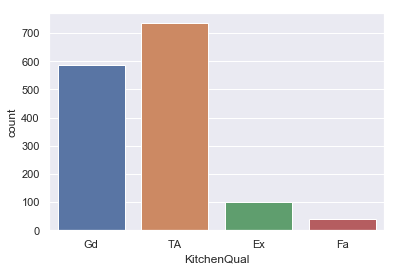

In [24]:
sns.countplot(df_train['KitchenQual'])

We've knew most of houses are expensive in our dataset. However, kitchen quality don't seems important in house prices.

### Bivariate Analysis

In [25]:
# Function that creates a scatterplot
def scatter_plot_bivariate(xlabel, ylabel, title, x, y): 
    plt.figure(figsize=(12,7))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(x, y ,'.', alpha = 0.3)

#### Numerical Variables

#### `YearBuilt` x `SalePrice`
Let's see if original construction date has influence in Sale Price

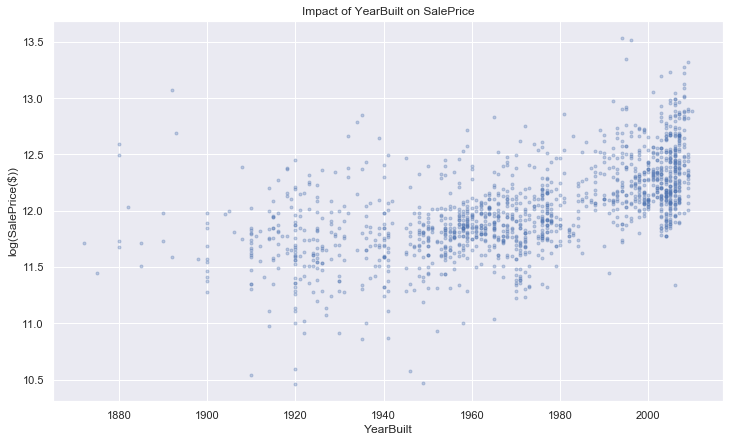

In [26]:
scatter_plot_bivariate("YearBuilt", "log(SalePrice($))", "Impact of YearBuilt on SalePrice", 
                      df_train.YearBuilt, df_train.SalePriceLog)

#### `Fireplaces` x `SalePrice`
As expected houses with fireplaces tend to be more expensive. However, we can see there are examples where a house with no fireplace was sold by the same price as houses with at least one.

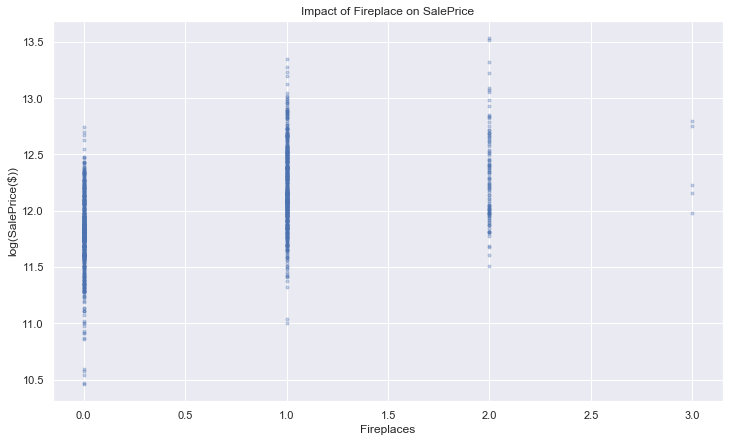

In [27]:
scatter_plot_bivariate("Fireplaces", "log(SalePrice($))", "Impact of Fireplace on SalePrice", 
                      df_train.Fireplaces, df_train.SalePriceLog)

#### `GarageCars` x `SalePrice`
As expected houses with parking spaces tend to be more expensive.

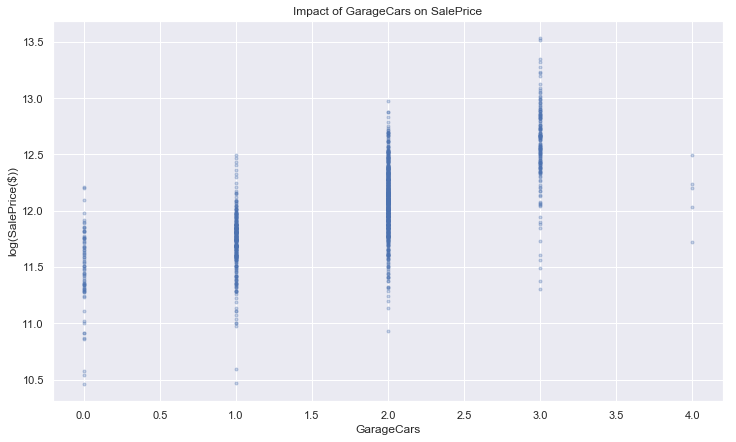

In [28]:
scatter_plot_bivariate("GarageCars", "log(SalePrice($))", "Impact of GarageCars on SalePrice", 
                      df_train.GarageCars, df_train.SalePriceLog)

Previously we saw that parking spots are important form buyers in Ames. Here we can observe that most houses have at least one parking place and that the higher that number the more expensive the house becomes. Similar to the previous example, houses with no parking spot were sold at the same price as houses with at least one, showing that this in an important predictor as the correlation showed,but not by itself.

#### `LotArea` x `SalePrice`

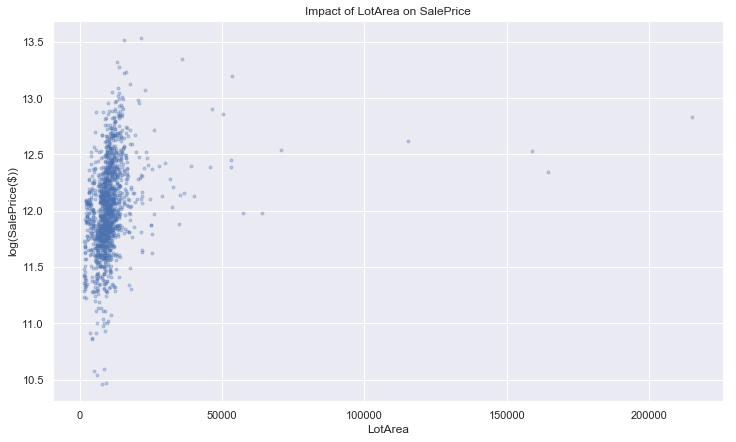

In [29]:
scatter_plot_bivariate("LotArea", "log(SalePrice($))", "Impact of LotArea on SalePrice", 
                      df_train.LotArea, df_train.SalePriceLog)

As the `LotArea` increases, so does the final price of the house. However, it seems there are some outliers.

#### `OverallQual` x `SalePrice`
In the section above we saw that OverallQual was the feature that had the highest correlation with SalePrice. It would be interesting to investigate deeper this relationship.

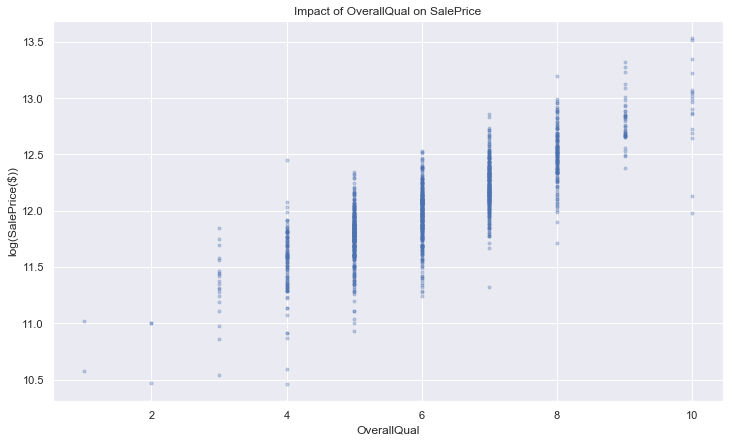

In [30]:
scatter_plot_bivariate("OverallQual", "log(SalePrice($))", "Impact of OverallQual on SalePrice", 
                      df_train.OverallQual, df_train.SalePriceLog)

As expected, the most expensive houses will have the highest OverallQual. Therefore, as the OverallQual increases so does the price of the house as the corr() showed previously.

#### `GrLivArea` x `SalePrice`
Usually when thinking about buying a house, its size its an important factor to determine the final price. Therefore, it might be interesting to see how `GrLivAre` affects the `SalePrice`.

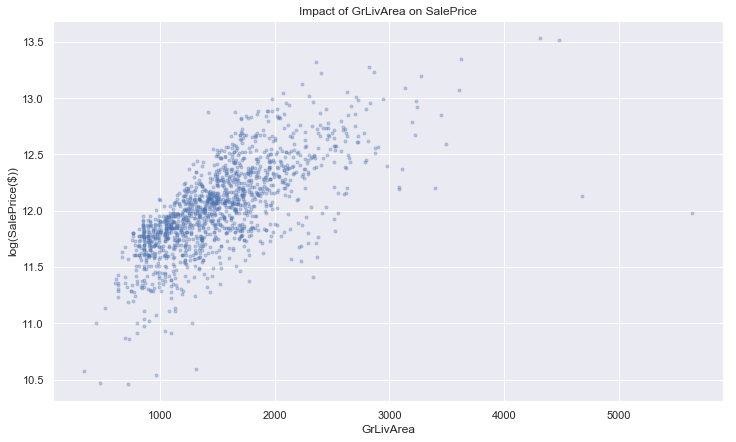

In [31]:
scatter_plot_bivariate("GrLivArea", "log(SalePrice($))", "Impact of GrLivArea on SalePrice", 
                      df_train.GrLivArea, df_train.SalePriceLog)

As the living area increases more expensive does the house becomes. However, it seems there are some outiliers.

#### `YearBuil` and `SalePrice` 
Most of the houses in the dataset were built in the last 10 years. However, if you look at the chart that plots the year when the house was built versus the median sale price we see that most recent homes sale at higher values(as expected) but there are also older houses from the beginning of the last century who also soldat high prices. Moreover, considering this is the mean sale price, and the number of houses in the 1900s is much lower the ratio of sale price is much higher.

<BarContainer object of 112 artists>

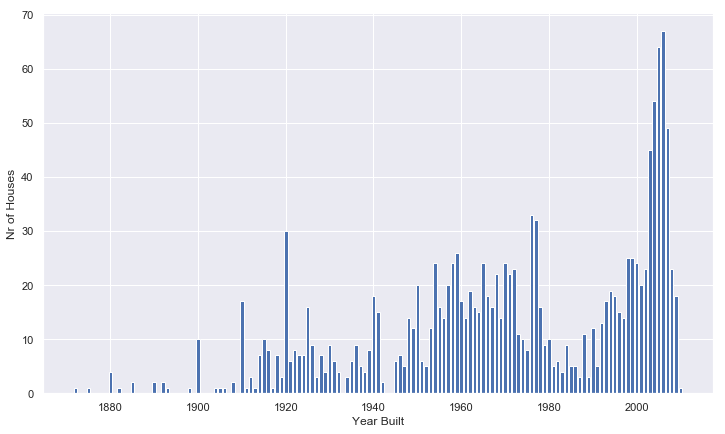

In [32]:
# Getting Year and Number of houses sold.
years = df_train['YearBuilt'].value_counts().reset_index(name='YearBuilt')
years.columns = ['YearBuilt', 'Count']

# Plot
plt.figure(figsize=(12,7))
plt.xlabel("Year Built")
plt.ylabel("Nr of Houses")
plt.bar(years["YearBuilt"], years["Count"])

Text(0, 0.5, 'Number of sold Houses')

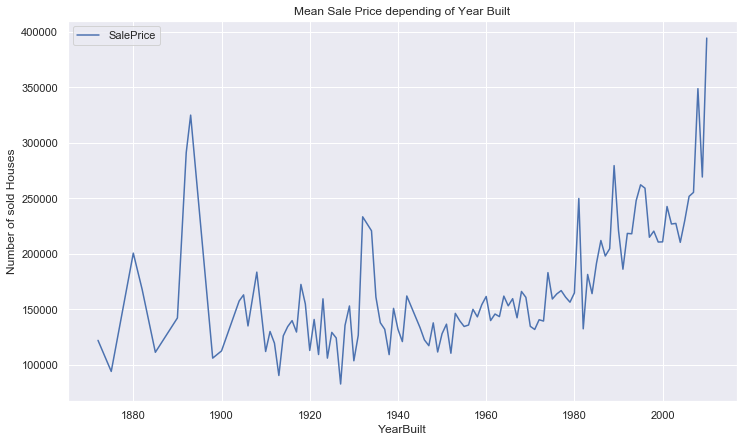

In [33]:
df_train[['YearBuilt','SalePrice']].groupby(['YearBuilt'], as_index=True).mean().plot(figsize=(12,7))
plt.title('Mean Sale Price depending of Year Built');
plt.ylabel('Number of sold Houses')

#### Categorical Variables

In [34]:
def stripplot_categorical(var_x, var_y):
    plt.figure(figsize=(12,7))
    sns.stripplot(x = var_x, y = var_y,
                  order = np.sort(var_x.unique()),
                  jitter=0.1, alpha=0.5)

    plt.xticks(rotation=45)

#### `Neighorhood` x `SalePrice`

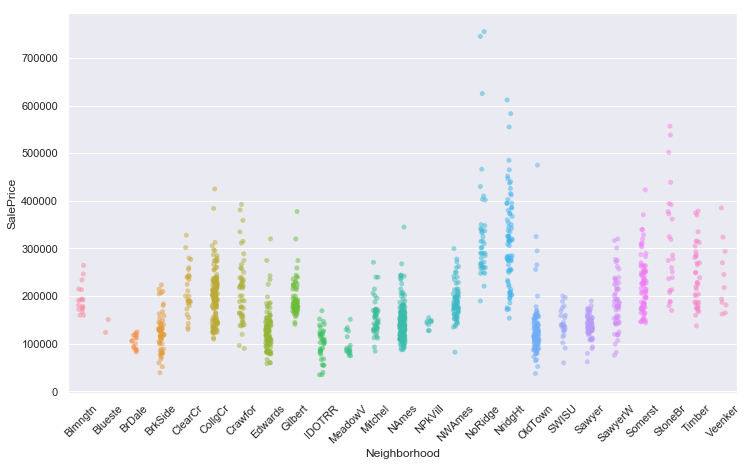

In [35]:
stripplot_categorical(df_train.Neighborhood, df_train.SalePrice)

As expected there are some neighborhoods more expensive than others.

 #### `Condition1` x `SalePrice`


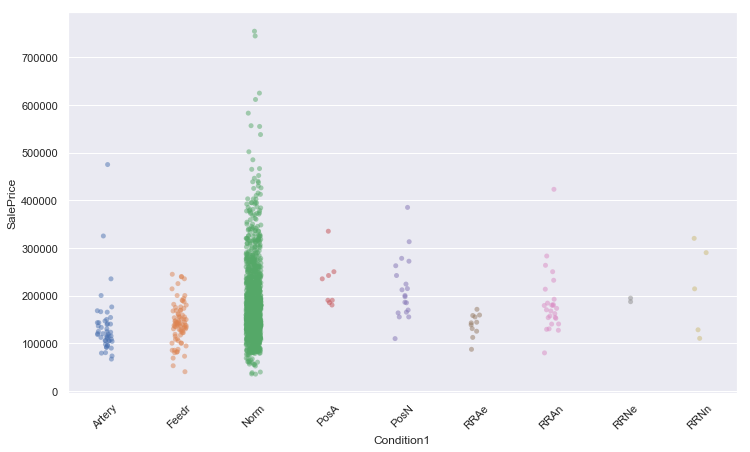

In [36]:
stripplot_categorical(df_train.Condition1, df_train.SalePrice)

### Data Pre-processing

In order not to repeat our cleaning steps twice (train and test) we’ll concatenate both datasets to apply any alteration and in the end will separate again the datasets. The column source will be added to help differentiate both sets.

In [37]:
# Join Train and Test Dataset
df_train['source'] = 'train'
df_test['source'] = 'test'
data = pd.concat([df_train, df_test], ignore_index = True, sort = False)
print(df_train.shape, df_test.shape, data.shape)

(1460, 83) (1459, 81) (2919, 83)


#### Outlier values
As we've saw above, there are some outliers in our dataset (`LotArea` and `GrLivArea`, for instance). So, let's delete them to get a precision model.

In [38]:
# Replacing our outliers with the mean, since Kaggle needs all houses in dataset
## GrLivArea
GrLivArea_mean = data['GrLivArea'].mean()
func = lambda x: x['GrLivArea'] > 4000 and GrLivArea_mean or x['GrLivArea']
data['GrLivArea'] = data.apply(func,axis=1).astype(float)

## LotArea
LotArea_mean = data['LotArea'].mean()
func = lambda x: x['LotArea'] > 50000 and LotArea_mean or x['LotArea']
data['LotArea'] = data.apply(func,axis=1).astype(float)

#### Thinking About Null or missing values
Another problem we have in our dataset is null or missing values. It's necessary analyze all features and check if make sense null or missing values. If not, we must replace to a valid value.

So, let’s start by searching for the features which have at least 30% of its values missing. Ignore the SalePrice since this is the target variable from the test dataset.

In [39]:
# Check variables that have at least 30% of missing values
features_null = data.isnull().sum() / data.shape[0] * 100
features_null[features_null > 30]

Alley           93.216855
FireplaceQu     48.646797
PoolQC          99.657417
Fence           80.438506
MiscFeature     96.402878
SalePrice       49.982871
SalePriceLog    49.982871
dtype: float64

As we can see, in both datasets (train and test), the same features have at least 30% of their data missing. Analyzing and thinking about what our features represent, it becomes clear that some of the missing or null values are in fact meaningful. For instance, missing values for garage and pool features simply imply that the house doesn't have a garage or a pool respectively. In this case, it makes sense to fill these missing values with something that captures this information. 

Analyzing `PoolQC`, for instance, the column refers to Pool Quality and it is **NaN** when `PoolArea` is **0**, or there isn't a pool.

#### Dealing with Null or Missing Values

##### Inputing NaN Values
Some features are not necessarily missing information but rather indicating they do not have any garage (`GarageType`, `GarageYrBuilt`, `GarageFinish`, `GarageCars` , `GarageArea` , `GarageQuat` and `GarageCondare`). Therefore, instead of deleting these attributes, we should add **NaN** values to those empty cells indicating the house has no garage.

In [40]:
# Input NaN values
none_values = data[['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                       'FireplaceQu', 'GarageType', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
                       'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'KitchenQual', 
                       'Functional', 'GarageFinish', 'SaleType', 'Electrical']]

data.update(none_values.fillna('None'))

##### Imputing 0 Values
For numeric features, when the house does not have attribute being measured it usually works to impute 0, for example number of cars that fit in a garage.

In [41]:
# Input 0 values
zero_values = data[['BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtFinSF1', 
                       'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'GarageCars']]

data.update(zero_values.fillna(0.0))

Regarding the feature `GarageYrBl` it is not clear what is the best solution. If the house has no garage how can we say when it was built? The year 0 makes no sense. Let’s assume the year the house it was built has the missing value.

In [42]:
# Replace 0.0 in GarageYrBlt to YearBuilt
data.update(data.GarageYrBlt.fillna(data.YearBuilt))

##### Inputing Random Values
These are the features which are still missing values. The reason why is not as clear as in the previous features, the reason might be they’re missing at random. In this case, we can delete, impute or leave as is.

In [43]:
# Check variables that still have missing values
features_null = data.isnull().sum() / data.shape[0] * 100
features_null[features_null > 0]

LotFrontage     16.649538
MasVnrArea       0.787941
SalePrice       49.982871
SalePriceLog    49.982871
dtype: float64

Since only `LotFrontag` as around 17% of missing data, deleting the features it is not an option (Because of Kaggle Requirement). Besides, most machine learning algorithms do not support **NaN** values, we have to impute the missing entries. In this case, we can replace each missing value with the mean , median , or mode of the given feature.

We will input theses values with yours median. So, let's do this.

In [44]:
# Input NaN values with mean
data.fillna(data.median(), inplace=True)

### Droping Correlation Features
As we have saw in our Exploratory Data Analysis, there were some features that had high correlation with others. Hence, we will drop `GarageArea` , `1stFlrS` , `TotRmsAbvGr`.

In [45]:
# Drop in train dataset  
data.drop(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd'], axis=1, inplace=True)

### Convert Non-numerical to Numerical Features
The most of our features are non-numerical and the majority of ML algorithms only accepts numbers as input. So, we must encode these non-numerical features. 

This transformation varies depending on the nature of the feature and the model we opt to go with. Usually, non-numerical variables tend to come in two flavours: ordinal and categorical. Ordinal variables — such as `OverallQual` or `LotShape` — have an intrinsic order to them, while purely Categorical variables — such as`Neighbourhood` or `Foundation` — do not. Let’s have a look at how to treat each of these in turn.

In [46]:
data.select_dtypes(include = [object]).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'source'],
      dtype='object')

#### Ordinal Features

The ordinal features, according with out dataset and cheking documentation are:

- `LotShape`
- `Utilities`
- `LandSlope`
- `OverallQual`
- `OverallCond`
- `Electrical`
- `ExterQual`
- `ExterCond`
- `BsmtQual`
- `BsmtCond`
- `BsmtExposure`
- `BsmtFinType1`
- `BsmtFinType2`
- `HeatingQC`
- `KitchenQual`
- `Functional`
- `FireplaceQu`
- `GarageFinish`
- `GarageQual`
- `GarageCond`
- `PavedDrive`
- `PoolQC`
- `Fence`

In [47]:
# Check content of Lotshape 
data.LotShape.unique()

# Replace values to number
data.LotShape = data.LotShape.replace({'None': -1, 'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3})
data.Utilities = data.Utilities.replace({'None': -1, 'AllPub':0, 'NoSeWa':1})
data.LandSlope = data.LandSlope.replace({'None': -1, 'Gtl':0, 'Mod':1, 'Sev':2})
data.ExterQual = data.ExterQual.replace({'None': -1, 'Gd':0, 'TA':1, 'Ex':2, 'Fa':3})
data.ExterCond = data.ExterCond.replace({'None': -1, 'TA':0, 'Gd':1, 'Fa':2, 'Po':3,'Ex':4})
data.BsmtQual = data.BsmtQual.replace({'None': -1, 'Gd':0, 'TA':1, 'Ex':2, 'None':3,'Fa':4})
data.BsmtCond = data.BsmtCond.replace({'None': -1, 'TA':0, 'Gd':1, 'None':2, 'Fa':3,'Po':4})
data.BsmtExposure = data.BsmtExposure.replace({'None': -1, 'No':0, 'Gd':1, 'Mn':2, 'Av':3,'None':4})
data.BsmtFinType1 = data.BsmtFinType1.replace({'None': -1, 'GLQ':0, 'ALQ':1, 'Unf':2, 'Rec':3, 'BLQ':4, 'None':5, 'LwQ':6})
data.BsmtFinType2 = data.BsmtFinType2.replace({'None': -1, 'Unf':0, 'BLQ':1, 'None':2, 'ALQ':3, 'Rec':4, 'LwQ':5, 'GLQ':6})
data.HeatingQC = data.HeatingQC.replace({'None': -1, 'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4})
data.Electrical = data.Electrical.replace({'None': -1, 'SBrkr':0, 'FuseF':1, 'FuseA':2, 'FuseP':3, 'Mix':4})
data.KitchenQual = data.KitchenQual.replace({'None': -1, 'Gd':0, 'TA':1, 'Ex':2, 'Fa':3})
data.Functional = data.Functional.replace({'None': -1, 'Typ':0, 'Min1':1, 'Maj1':2, 'Min2':3, 'Mod':4, 'Maj2':5, 'Sev':6})
data.FireplaceQu = data.FireplaceQu.replace({'None':0, 'TA':1, 'Gd':2, 'Fa':3, 'Ex':4, 'Po':5})
data.GarageFinish = data.GarageFinish.replace({'None': -1, 'RFn':0, 'Unf':1, 'Fin':2, 'None':3})
data.GarageQual = data.GarageQual.replace({'None': -1, 'TA':0, 'Fa':1, 'Gd':2, 'None':3, 'Ex':4, 'Po':5})
data.GarageCond = data.GarageCond.replace({'None': -1, 'TA':0, 'Fa':1, 'None':2, 'Gd':3, 'Po':4, 'Ex':5})
data.PavedDrive = data.PavedDrive.replace({'None': -1, 'Y':0, 'N':1, 'P':2})
data.PoolQC = data.PoolQC.replace({'None':0, 'Ex':1, 'Fa':2, 'Gd':3})
data.Fence = data.Fence.replace({'None':0, 'MnPrv':1, 'GdWo':2, 'GdPrv':3, 'MnWw':4})

#### Categorical Features
These are our categorical features:
- `MSZoning`
- `Street` 
- `Alley` 
- `LandContour` 
- `LotConfig` 
- `Neighborhood` 
- `Condition1` 
- `Condition2` 
- `BldgType` 
- `HouseStyle` 
- `RoofStyle` 
- `RoofMat1` 
- `Exterior1st` 
- `Exterior2nd` 
- `MasVnrType` 
- `Foundation` 
- `Heating` 
- `CentralAir` 
- `GarageType` 
- `MiscFeature` 
- `SaleType` 
- `SaleCondition`

Now, we can replace all categorical variables into numerical values using **LabelEnconder()** (Encodes labels with value between 0 and n_classes-1) from sklearn’s preprocessing module! 

After that, we can use **get_dummies** to generate dummy variables from these numerical categorical variables.

In [48]:
labelEncoder = LabelEncoder()

# Features for replace
cate_ftrs = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", 
              "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl" ,
              "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", 
              "GarageType", "MiscFeature" ,"SaleType" , "SaleCondition"]
for item in cate_ftrs:
    data[item] = labelEncoder.fit_transform(data[item])
    
# Dummy Variables:
data = pd.get_dummies(data, columns = cate_ftrs)

### Feature Engineering
Process of using domain knowledge of our data to create features that make machine learning algorithms more powerfull.

Then, we will create new features in 2 ways :

- Simplifications of existing features
- Combinations of existing features

#### Simplifications

In [49]:
data["SimplOverallQual"] = data.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                     4 : 2, 5 : 2, 6 : 2, # average
                                                     7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                    })

data["SimplOverallCond"] = data.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                     4 : 2, 5 : 2, 6 : 2, # average
                                                     7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                    })

data["SimplPoolQC"] = data.PoolQC.replace({1 : 1, 2 : 1, # average
                                           3 : 2, 4 : 2 # good
                                          })

data["SimplGarageCond"] = data.GarageCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

data["SimplGarageQual"] = data.GarageQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

data["SimplFireplaceQu"] = data.FireplaceQu.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })

data["SimplFireplaceQu"] = data.FireplaceQu.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })

data["SimplFunctional"] = data.Functional.replace({1 : 1, 2 : 1, # bad
                                                   3 : 2, 4 : 2, # major
                                                   5 : 3, 6 : 3, 7 : 3, # minor
                                                   8 : 4 # typical
                                                  })

data["SimplKitchenQual"] = data.KitchenQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })

data["SimplHeatingQC"] = data.HeatingQC.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })

data["SimplBsmtFinType1"] = data.BsmtFinType1.replace({1 : 1, # unfinished
                                                       2 : 1, 3 : 1, # rec room
                                                       4 : 2, 5 : 2, 6 : 2 # living quarters
                                                      })

data["SimplBsmtFinType2"] = data.BsmtFinType2.replace({1 : 1, # unfinished
                                                       2 : 1, 3 : 1, # rec room
                                                       4 : 2, 5 : 2, 6 : 2 # living quarters
                                                      })

data["SimplBsmtCond"] = data.BsmtCond.replace({1 : 1, # bad
                                               2 : 1, 3 : 1, # average
                                               4 : 2, 5 : 2 # good
                                              })

data["SimplBsmtQual"] = data.BsmtQual.replace({1 : 1, # bad
                                               2 : 1, 3 : 1, # average
                                               4 : 2, 5 : 2 # good
                                              })

data["SimplExterCond"] = data.ExterCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })

data["SimplExterQual"] = data.ExterQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })

#### New Features

##### New Houses
If `Year Sold` is the same of `Year Built`, we talking about a new house and there may be a high demand of it.

In [50]:
data['NewHouse'] = data['YrSold'] - data['YearBuilt']
func = lambda x: x['NewHouse'] == 0 and 1.0 or 0.0
data['NewHouse'] = data.apply(func, axis=1).astype(float)

##### All Square Feet
Total square feet of the house

In [51]:
# Total SF for house (incl. basement)
data["AllSF"] = data["GrLivArea"] + data["TotalBsmtSF"]

#### Finding the best features

In [52]:
print("Find most important features relative to target")
corr = data.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000000
SalePriceLog         0.942068
AllSF                0.558791
OverallQual          0.542911
GrLivArea            0.498442
SimplOverallQual     0.462944
GarageCars           0.438681
TotalBsmtSF          0.428251
FullBath             0.389208
YearBuilt            0.363825
YearRemodAdd         0.354414
GarageYrBlt          0.346609
Foundation_2         0.345669
MasVnrArea           0.334995
SimplFireplaceQu     0.329501
Fireplaces           0.329184
FireplaceQu          0.278739
BsmtFinSF1           0.270938
Neighborhood_16      0.268252
LotArea              0.263796
SaleType_6           0.252975
Neighborhood_15      0.251324
SaleCondition_5      0.249059
LotFrontage          0.245915
GarageType_1         0.235926
MasVnrType_3         0.235017
2ndFlrSF             0.230918
WoodDeckSF           0.225070
OpenPorchSF          0.214320
Exterior1st_13       0.213763
                       ...   
Exterior2nd_8       -0

### Split Train and Test DataSet

In [55]:
# Divide into test and train dataset
train = data.loc[data['source'] == "train"]
test = data.loc[data['source'] == "test"]

# Define target variable
target_train = train.SalePrice

# Drop unnecessary columns:
test.drop(['SalePrice', 'SalePriceLog', 'source'], axis=1, inplace=True)
train.drop(['SalePrice', 'SalePriceLog', 'source'], axis=1, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Models

### Linear Regression

In [56]:
from sklearn import linear_model

# Train the model
model = linear_model.LinearRegression()

# Fit the model
model.fit(train, target_train)

# Prediction
model.predict(train)

# Score/Accuracy
print("Accuracy -> ", model.score(train, target_train)*100)

Accuracy ->  91.95283984895939


### RandomForestRegression

In [57]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
model = RandomForestRegressor(n_estimators=1000)

# Fit the model
model.fit(train, target_train)

# Prediction
model.predict(train)

# Score / Accuracy
print("Accuracy -> ", model.score(train, target_train)*100)

Accuracy ->  98.12922252156042


### GradientBoostingRegressor

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

# Train the model
model = GradientBoostingRegressor(n_estimators=100, max_depth=4)

# Fit the model
model.fit(train, target_train)

# Prediction
model.predict(train)

# Score / Accuracy
print("Accuracy -> ", model.score(train, target_train)*100)

Accuracy ->  98.08143837504969


## Kaggle

In [60]:
# Prepare archive
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission['SalePrice'] = model.predict(test)

# Export archive
submission.to_csv('submission.csv', index = False)